In [1]:
import os
import sys
while not os.getcwd().endswith('ml'):
    os.chdir('..')
sys.path.insert(0, os.getcwd())

In [23]:
import math
import copy
import cv2
import pandas as pd
import numpy as np
import random
from shutil import copyfile
from pathlib import Path
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from ml_helpers.image_helpers import display_images
from ml_helpers.common_helpers import display_history_metrics

from sklearn.model_selection import train_test_split
import pickle

from kaggle_problems.rosneft_proppant.workspace.common import bins

from kaggle_problems.rosneft_proppant.workspace.common import TARGET_SHAPE

/Users/skrrydg/Desktop/Code/ml/ml_helpers/common_helpers.py:19: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  epochs = len(history[keys[0]])


In [3]:
DATA_DIR = "kaggle_problems/rosneft_proppant/workspace/data/"
MODEL_DIR = "kaggle_problems/rosneft_proppant/workspace/models"
DF_RATE = 1.

In [4]:
train = pd.read_csv("{}labels/labels.csv".format(DATA_DIR))
train.describe()

,ImageId,6,7,8,10,12,14,16,18,20,...,35,40,45,50,60,70,80,100,pan,prop_count
count,790.000000,756.0,756.0,756.0,756.0,756.0,756.0,756.000000,756.000000,756.000000,...,756.000000,756.000000,756.000000,756.000000,756.0,756.0,756.0,756.0,756.0,64.000000
mean,395.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.011115,0.325205,0.376608,...,0.009513,0.033514,0.000036,0.000072,0.0,0.0,0.0,0.0,0.0,1868.812500
std,228.197648,0.0,0.0,0.0,0.0,0.0,0.0,0.008205,0.235431,0.233366,...,0.030045,0.073941,0.000495,0.000363,0.0,0.0,0.0,0.0,0.0,718.401883
min,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.006100,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,688.000000
25%,198.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.005146,0.008131,0.090836,...,0.000000,0.000300,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1204.750000
50%,395.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.370200,0.435100,...,0.000000,0.000600,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1955.500000
75%,592.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.015650,0.486200,0.563200,...,0.000000,0.005600,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,2487.000000
max,790.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.041200,0.844800,0.825500,...,0.187500,0.270995,0.007800,0.005100,0.0,0.0,0.0,0.0,0.0,3029.000000


In [5]:
sources = ['bw', 'colored', 'threshed']
source_to_fraction = {
    'bw': 'bw',
    'colored': 'colored',
    'threshed': 'bw'
}

In [6]:
def enrich_fraction(train):
    for fraction in source_to_fraction.values():
        img_numbers = [int(img[0:-len(".jpg")]) for img in os.listdir(DATA_DIR + fraction + "_main_area") if img.endswith('.jpg')]
        train.loc[train.ImageId.isin(img_numbers), 'fraction'] = fraction
    return train

def get_fraction_sievs(train, fraction):
    train_fraction = train[train.fraction == fraction]
    result_bins = []
    for b in bins:
        if train_fraction[b].sum() > 1e-5:
            result_bins.append(b)
    return result_bins
        

In [7]:
train.fraction = None
train = enrich_fraction(train)

In [8]:
train = train[~train.fraction.isnull()]

In [9]:
for i in bins:
    train = train[~train[i].isnull()]

train["filename"] = train['ImageId'].astype(str) + '.jpg'

In [10]:
fraction_sievs = {}
for fraction in source_to_fraction.values():
    fraction_sievs[fraction] = get_fraction_sievs(train, fraction)

In [20]:
print(fraction_sievs)

{'bw': ['16', '18', '20', '25', '30', '35', '40', '45', '50'], 'colored': ['16', '18', '20', '25', '30', '40']}


### Model

In [11]:
class BinsExtraction(Model):
    def __init__(self, fraction):
        super(BinsExtraction, self).__init__()
        self.FilterSize1 = 32
        self.FilterSize2 = 16
        self.FilterSize3 = 8
        
        self.model_layers = [
            tf.keras.layers.Conv2D(filters=self.FilterSize1, kernel_size=(5, 5), strides=(5, 5)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(rate=0.3),

            tf.keras.layers.Conv2D(filters=self.FilterSize2, kernel_size=(3, 3), strides=(3, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(rate=0.3),
            
            tf.keras.layers.Conv2D(filters=self.FilterSize3, kernel_size=(3, 3), strides=(3, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(rate=0.3),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(rate=0.5),
            tf.keras.layers.Dense(len(fraction_sievs[fraction]), activation='softmax'),
        ]

    def call(self, x, *args, **kwargs):
        for model_layer in self.model_layers:
            x = model_layer(x, *args, **kwargs)
        return x

#### Train Input Generator

In [12]:
def get_train_val_datagen(train, source, train_size=0.8):
    fraction = source_to_fraction[source]
    train_fraction = train[train['fraction'] == source_to_fraction[source]]
    
    train_fraction, val_fraction = train_test_split(train_fraction, train_size=train_size, random_state=123)
    
    bins_fraction = fraction_sievs[fraction]
    
    datagen = ImageDataGenerator()

    train_generator = datagen.flow_from_dataframe(
            train_fraction.sample(n=int(len(train_fraction) * DF_RATE)),
            directory="kaggle_problems/rosneft_proppant/workspace/data/{}_main_area".format(source),
            x_col='filename', 
            y_col=bins_fraction,
            target_size=TARGET_SHAPE,
            batch_size=16,
            class_mode='other',
    )
    
    val_generator = datagen.flow_from_dataframe(
        val_fraction.sample(n=int(len(val_fraction) * DF_RATE)),
        directory="kaggle_problems/rosneft_proppant/workspace/data/{}_main_area".format(source),
        x_col='filename', 
        y_col=bins_fraction,
        target_size=TARGET_SHAPE,
        batch_size=16,
        class_mode='other')
    return train_generator, val_generator

#### Input generator checking

/Users/skrrydg/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Found 32 validated image filenames.
Found 8 validated image filenames.


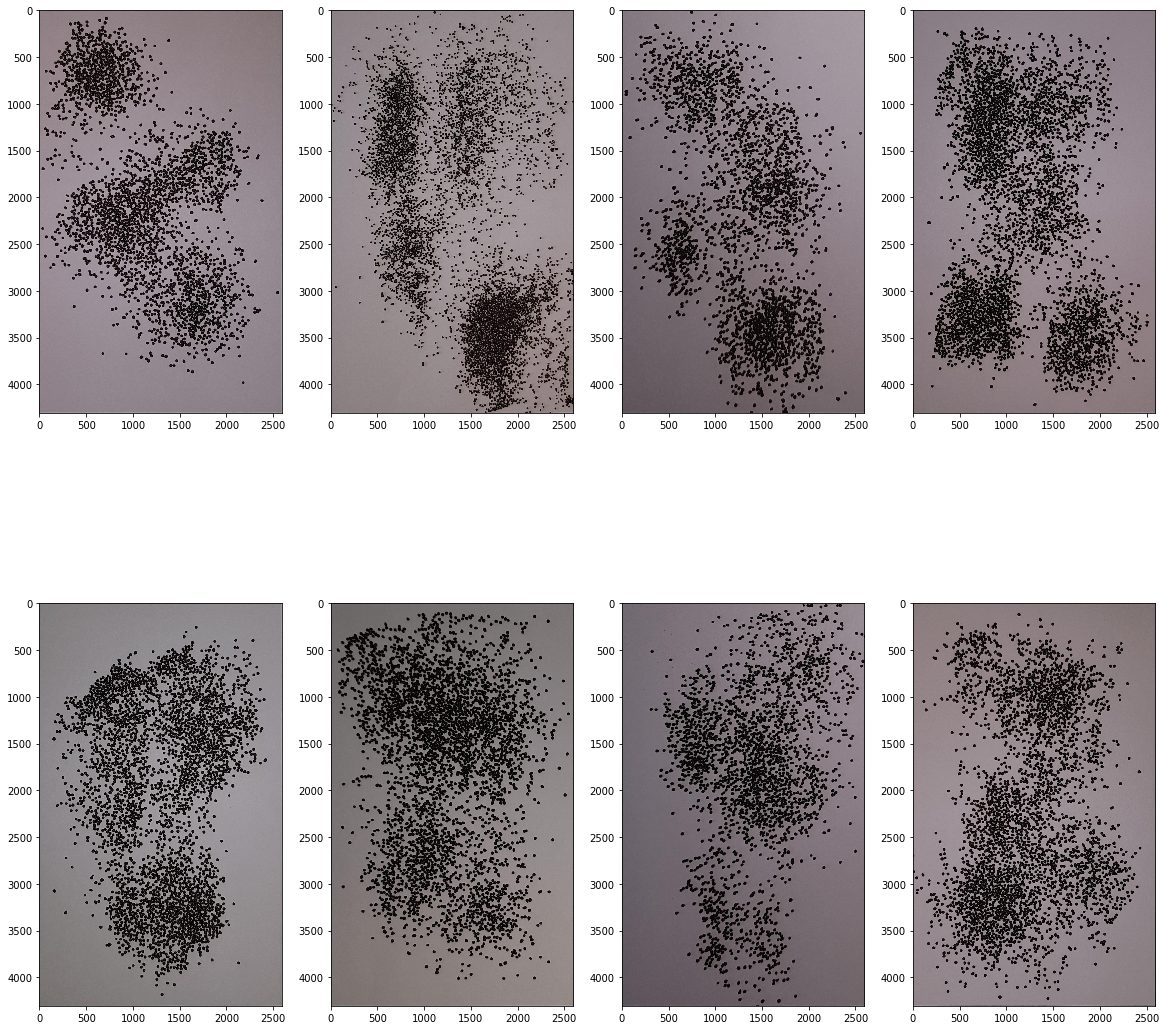

In [13]:
img, labels = get_train_val_datagen(train, 'bw')[0].next()
display_images(img[0:8].astype(int), 4)

#### Callbacks

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

earlystop = EarlyStopping(patience=10)

callbacks = [earlystop, learning_rate_reduction]

In [16]:
def metric(true, predicted):
    return tf.keras.backend.mean(tf.math.reduce_sum((true - predicted) ** 2 / (true + predicted), axis=1))

In [18]:
for source, i in zip(sources, range(len(sources))):
    fraction = source_to_fraction[source]
    model = BinsExtraction(fraction)
    model.compile(
        loss=metric,
        optimizer='rmsprop',
    )

    train_datagen, val_datagen = get_train_val_datagen(train, source)

    history = model.fit(
        x=train_datagen,
        epochs=50,
        validation_data=val_datagen,
        callbacks=callbacks
    )
    
    Path(MODEL_DIR).mkdir(exist_ok=True, parents=True)
    
    with open(MODEL_DIR + "/history_model_benchmark_{}.pickle".format(source), 'wb') as f:
        pickle.dump(history.history, f)
        
    model.save(MODEL_DIR + "/model_benchmark_{}".format(source))

/Users/skrrydg/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Found 32 validated image filenames.
Found 8 validated image filenames.


KeyboardInterrupt: 

In [ ]:
def get_bins_metric(predicted, true):
    return 0.5 * np.sum((predicted - true) ** 2 / (predicted + true)) / predicted.shape[0]

def get_bins_metric_by_image(predicted, true):
    return np.sum(0.5 * (predicted - true) ** 2 / (predicted + true), axis=1)

def get_bins_metric_by_bins(predicted, true):
    return np.sum(0.5 * (predicted - true) ** 2 / (predicted + true), axis=0)

In [ ]:
#print("Total bin loss: {}".format(get_bins_metric(predicted_labels, all_labels)))

bw----------------------------------------------------------------------------------------------------


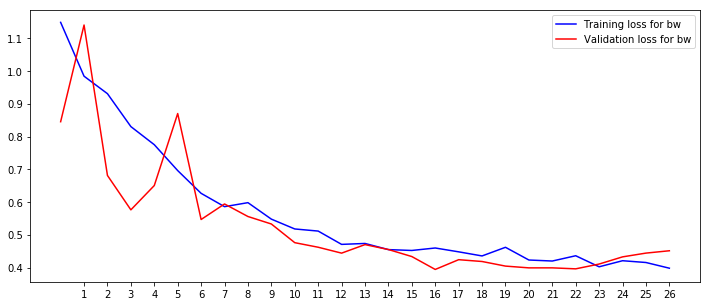

bw----------------------------------------------------------------------------------------------------
colored----------------------------------------------------------------------------------------------------


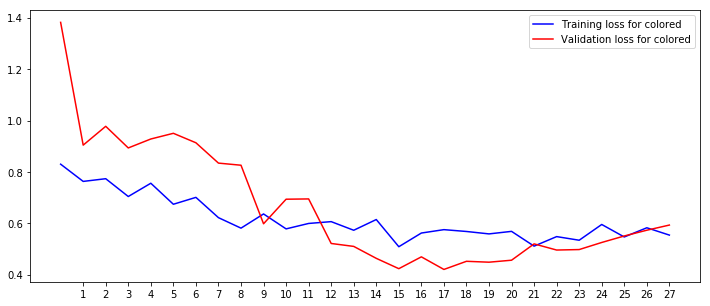

colored----------------------------------------------------------------------------------------------------
threshed----------------------------------------------------------------------------------------------------


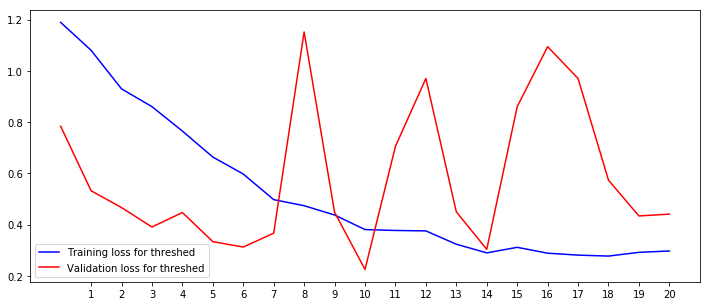

threshed----------------------------------------------------------------------------------------------------


In [32]:
for source, i in zip(sources, range(len(sources))):
    fraction = source_to_fraction[source]
    print(source + "-" * 100)
    from keras.utils.generic_utils import get_custom_objects

    get_custom_objects().update({'metric': metric})

    with open(MODEL_DIR + "/history_model_benchmark_{}.pickle".format(source), 'rb') as f:
        history = pickle.load(f)

    model = tf.keras.models.load_model(MODEL_DIR + "/model_benchmark_{}".format(source), 
                                       compile=False)
    model.compile(
        loss=metric,
        optimizer='rmsprop',
       # metrics=['mse']
    )                                                                               

    display_history_metrics(history, source)
    print(source + '-' * 100)
    
#     train_datagen = get_train_val_datagen(train, fraction)[0]

#     predicted_labels = []
#     all_labels = []
#     train_fraction = train[train['fraction'] == fraction]

#     for i in range(int(train_fraction.shape[0]) // 16):
#         imgs, labels = train_datagen.next()
#         predicted_labels.extend(model.predict(imgs))
#         all_labels.extend(labels)
#     predicted_labels = np.array(predicted_labels)
#     all_labels = np.array(all_labels)

#     losses_by_img = get_bins_metric_by_image(predicted_labels, all_labels)
#     plt.hist(losses_by_img, bins=100)
#     plt.show()

#     losses_by_bins = get_bins_metric_by_bins(predicted_labels, all_labels)
#     plt.hist(losses_by_bins, bins=100)
#     plt.show()
#     print("-" * 50)

In [19]:
!jupyter nbconvert --to script kaggle_problems/rosneft_proppant/cnn_try.ipynb

[NbConvertApp] Converting notebook kaggle_problems/rosneft_proppant/cnn_try.ipynb to script
[NbConvertApp] Writing 8489 bytes to kaggle_problems/rosneft_proppant/cnn_try.py
